# model

> Defines data and processing structures.

In [ ]:
#| default_exp model

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path
import json
from datetime import datetime, timezone
import ipywidgets as w
import matplotlib.pyplot as plt
import multiprocessing

In [ ]:
#| export
from typing import Tuple, Dict, Callable, Optional, Any, List, Union
from matplotlib.figure import Figure
from matplotlib.axes._axes import Axes 

In [ ]:
#| export
from neuralactivitycubic.datamodels import AnalysisConfig, ResultsConfig, AnalysisJobConfig
from neuralactivitycubic.processing import AnalysisJob
from neuralactivitycubic.input import RecordingLoaderFactory, ROILoaderFactory, RecordingLoader, ROILoader, get_filepaths_with_supported_extension_in_dirpath, FocusAreaPathRestrictions

In [ ]:
#| export
class Model:

    def __init__(self) -> None:
        self.num_processes = multiprocessing.cpu_count()
        self.analysis_job_queue = []
        self.logs = []
        self.gui_enabled = False


    def setup_connection_to_update_infos_in_view(self, update_infos: Callable) -> None:
        self.callback_view_update_infos = update_infos
        self._check_if_gui_setup_is_completed()


    def setup_connection_to_display_results(self, show_output_screen: Callable, output: w.Output, pixel_conversion: float) -> None:
        self.callback_view_show_output_screen = show_output_screen
        self.view_output = output
        self.pixel_conversion = pixel_conversion
        self._check_if_gui_setup_is_completed()


    def _check_if_gui_setup_is_completed(self) -> None:
        checklist_expected_attributes_with_type = {'callback_view_update_infos': Callable,
                                                   'callback_view_show_output_screen': Callable,
                                                   'view_output': w.Output,
                                                   'pixel_conversion': float}
        confirmed_attributes = []
        failed_attributes = []
        for attribute_name, expected_type in checklist_expected_attributes_with_type.items():
            if hasattr(self, attribute_name) == True:
                attribute = getattr(self, attribute_name)
                if type(attribute) == expected_type:
                    confirmed_attributes.append(True)
                elif isinstance(attribute, expected_type):
                    confirmed_attributes.append(True)
                else:
                    failed_attributes.append(attribute_name)
            else:
                failed_attributes.append(attribute_name)
        if len(confirmed_attributes) == len(checklist_expected_attributes_with_type.keys()):
            self.gui_enabled = True
            self.add_info_to_logs('NA3 GUI initialization completed. Start by selecting and loading source data.', True)
        else:
            self.gui_enabled = False
            for attribute_name in failed_attributes:
                self.add_info_to_logs(f'Setup of {attribute_name} missing before GUI connection can be enabled.')


    def add_info_to_logs(self, message: str, display_in_gui: bool=False, progress_in_percent: Optional[float]=None) -> None:
        time_prefix_in_utc = datetime.now(timezone.utc).strftime('%d-%m-%y %H:%M:%S.%f')
        self.logs.append(f'{time_prefix_in_utc} (UTC): {message}')
        if (display_in_gui == True) and (self.gui_enabled == True): 
            self.callback_view_update_infos(message, progress_in_percent)


    def create_analysis_jobs(self, configs: Dict[str, Any]) -> None:
        self._ensure_data_from_previous_jobs_was_removed()
        analysis_job_config = AnalysisJobConfig.validate(configs)
        self.add_info_to_logs('Basic configurations for data import validated. Starting creation of analysis job(s)...', True)
        if analysis_job_config['batch_mode'] == True:
            all_subdir_paths_with_rec_file = self._get_all_subdir_paths_with_rec_file(analysis_job_config['data_source_path'])
            all_subdir_paths_with_rec_file.sort()
            total_step_count = len(all_subdir_paths_with_rec_file)
            progress_step_size = 100 / total_step_count
            for idx, subdir_path in enumerate(all_subdir_paths_with_rec_file):
                self.add_info_to_logs(f'Starting with Job creation(s) for {subdir_path} ...', True)
                self._create_and_add_analysis_jobs_to_queue_for_single_rec(subdir_path, analysis_job_config['roi_mode'], analysis_job_config['focus_area_enabled'])
                self.add_info_to_logs(f'Finished Job creation(s) for {subdir_path}!', True, min((idx+1)*progress_step_size, 100.0))
        else:
            self.add_info_to_logs(f'Starting with Job creation(s) for {analysis_job_config["data_source_path"]} ...', True)
            self._create_and_add_analysis_jobs_to_queue_for_single_rec(analysis_job_config['data_source_path'], analysis_job_config['roi_mode'], analysis_job_config['focus_area_enabled'])
            self.add_info_to_logs(f'Finished Job creation(s) for {analysis_job_config["data_source_path"]}!', True, 100.0)
        self.add_info_to_logs('All job creation(s) completed.', True, 100.0)


    def _ensure_data_from_previous_jobs_was_removed(self) -> None:
        # if we are deleting all data anyway, why bother checking?
        if len(self.analysis_job_queue) > 0:
            self.add_info_to_logs('Loading of new source data. All previously created jobs & logs will be deleted.', True)
            self.analysis_job_queue = []
            self.logs = []
            self._check_if_gui_setup_is_completed()


    def _get_all_subdir_paths_with_rec_file(self, top_level_dir_path: Path) -> List[Path]:
        rec_loader_factory = RecordingLoaderFactory()
        supported_extensions_for_recordings = rec_loader_factory.all_supported_extensions
        all_subdir_paths_that_contain_a_supported_recording_file = []
        for elem in top_level_dir_path.iterdir():
            if elem.name.startswith('.') == False:
                if elem.is_dir():
                    supported_recording_filepaths = [elem_2 for elem_2 in elem.iterdir() if elem_2.suffix in supported_extensions_for_recordings]
                    if len(supported_recording_filepaths) > 0:
                        all_subdir_paths_that_contain_a_supported_recording_file.append(elem)
        return all_subdir_paths_that_contain_a_supported_recording_file


    def _create_and_add_analysis_jobs_to_queue_for_single_rec(self, data_source_path: Path, roi_mode: str, focus_area_enabled: bool) -> None:
        recording_loader = self._get_recording_loader(data_source_path)
        if roi_mode == 'file':
            roi_loaders = self._get_all_roi_loaders(data_source_path)
        else:
            roi_loaders = None
        if focus_area_enabled == True:
            focus_area_dir_path = self._get_focus_area_dir_path(data_source_path)
            if focus_area_dir_path == None:
                analysis_job = self._create_single_analysis_job(recording_loader, roi_loaders)
                self.analysis_job_queue.append(analysis_job)
                self.add_info_to_logs(f'Successfully created a single job for {data_source_path} at queue position: #{len(self.analysis_job_queue)}.', True)
            else:
                all_focus_area_loaders = self._get_all_roi_loaders(focus_area_dir_path)
                assert len(all_focus_area_loaders) > 0, f'Focus Area analysis enabled, but no focus area ROIs could be found. Please revisit your source data and retry!'
                for idx, focus_area_loader in enumerate(all_focus_area_loaders):
                    analysis_job_with_focus_area = self._create_single_analysis_job(recording_loader, roi_loaders, focus_area_loader)
                    self.analysis_job_queue.append(analysis_job_with_focus_area)
                    job_creation_message = (f'Successfully created {idx + 1} out of {len(all_focus_area_loaders)} job(s) for {data_source_path} '
                                            f'at queue position: #{len(self.analysis_job_queue)}.')
                    self.add_info_to_logs(job_creation_message, True)
        else:
            analysis_job = self._create_single_analysis_job(recording_loader, roi_loaders)
            self.analysis_job_queue.append(analysis_job)
            self.add_info_to_logs(f'Successfully created a single job for {data_source_path} at queue position: #{len(self.analysis_job_queue)}.', True)


    def _get_recording_loader(self, data_source_path) -> RecordingLoader:
        rec_loader_factory = RecordingLoaderFactory()
        if data_source_path.is_dir() == True:
            self.add_info_to_logs(f'Looking for a valid recording file in {data_source_path}...', True)
            valid_filepaths = get_filepaths_with_supported_extension_in_dirpath(data_source_path, rec_loader_factory.all_supported_extensions, 1)
            if len(valid_filepaths) == 0:
                self.add_info_to_logs(f'Could not find any recording files of supported type at {data_source_path}!', True)
            elif len(valid_filepaths) >  1:
                recording_filepath = valid_filepaths[0]
                too_many_files_message = (f'Found more than a single recording file of supported type at {data_source_path}, i.e.: {valid_filepaths}. '
                                          f'However, only a single file was expected. NA3 continues with {recording_filepath} and will ignore the other files.')
                self.add_info_to_logs(too_many_files_message, True)
            else:
                recording_filepath = valid_filepaths[0]
                self.add_info_to_logs(f'Found recording file of supported type at: {recording_filepath}.', True)
        else:
            recording_filepath = data_source_path
            self.add_info_to_logs(f'Found recording file of supported type at: {recording_filepath}.', True)
        recording_loader = rec_loader_factory.get_loader(recording_filepath)
        return recording_loader


    def _get_all_roi_loaders(self, data_source_path: Path) -> List[ROILoader]:
        assert data_source_path.is_dir(), f'You must provide a directory as source data when using ROI mode or enabling Focus Areas. Please revisit your input data and retry.'
        roi_loader_factory = ROILoaderFactory()
        all_filepaths_with_supported_filetype_extensions = get_filepaths_with_supported_extension_in_dirpath(data_source_path, roi_loader_factory.all_supported_extensions)
        all_roi_loaders = [roi_loader_factory.get_loader(roi_filepath) for roi_filepath in all_filepaths_with_supported_filetype_extensions]
        return all_roi_loaders


    def _get_focus_area_dir_path(self, data_source_path: Path) -> Path:
        focus_area_path_restrictions = FocusAreaPathRestrictions()
        supported_dir_names = focus_area_path_restrictions.supported_dir_names
        if data_source_path.is_dir():
            source_dir_path = data_source_path
        else:
            source_dir_path = data_source_path.parent
        dirs_with_valid_name = [elem for elem in source_dir_path.iterdir() if (elem.name in supported_dir_names) & (elem.is_dir() == True)]
        if len(dirs_with_valid_name) == 0:
            no_dir_found_message = (f'You enabled Focus Area but a correspondingly named directory could not be found in {source_dir_path}. '
                                    f'Please use one of the following for the name of the directory that contains the Focus Area ROIs: {supported_dir_names}. '
                                    'In absence of such a directory, analysis is continued without using the Focus Area mode for this data.')
            self.add_info_to_logs(no_dir_found_message, True)
            focus_area_dir_path = None
        elif len(dirs_with_valid_name) > 1:
            too_many_dirs = (f'More than a single Focus Area directory was found in the following parent directory: {source_dir_path}, i.e.: '
                             f'{dirs_with_valid_name}. However, only the use of a single one that contains all your Focus Area ROIS is '
                             f'currently supported. {dirs_with_valid_name[0]} will be used for this analysis, while the other(s): {dirs_with_valid_name[1:]} '
                             'will be ignored to continue processing.')
            self.add_info_to_logs(too_many_dirs, True)
            focus_area_dir_path = dirs_with_valid_name[0]
        else:
            focus_area_dir_path = dirs_with_valid_name[0]
        return focus_area_dir_path


    def _create_single_analysis_job(self, recording_loader: RecordingLoader, roi_loaders: Union[List[ROILoader], None], focus_area_loader: Optional[ROILoader]=None) -> AnalysisJob:
        data_loaders = {'recording': recording_loader}
        if roi_loaders != None:
            data_loaders['rois'] = roi_loaders
        if focus_area_loader != None:
            data_loaders['focus_area'] = focus_area_loader
        return AnalysisJob(self.num_processes, data_loaders)

    def run_analysis(self, configs: Dict[str, Any]) -> None:
        analysis_config = AnalysisConfig.validate(configs)
        results_config = ResultsConfig.validate(configs)
        self.add_info_to_logs('Configurations for Analysis Settings and Result Creation validated successfully.', True)
        self.add_info_to_logs(f'Analysis Settings are:')
        for key, value in configs.items():
            self.add_info_to_logs(f'{key}: {str(value)}')     
        self.add_info_to_logs('Starting analysis...', True)
        total_step_count = len(self.analysis_job_queue)
        progress_step_size = 100 / total_step_count
        for job_idx, analysis_job in enumerate(self.analysis_job_queue):
            self.add_info_to_logs(f'Starting to process analysis job with index #{job_idx}.')
            analysis_job.run_analysis(**analysis_config)
            self.add_info_to_logs(f'Analysis successfully completed. Continue with creation of results.. ')
            analysis_job.create_results(**results_config)
            self.add_info_to_logs(f'Results successfully created at: {analysis_job.results_dir_path}')
            if self.gui_enabled == True:
                self.callback_view_show_output_screen()
                with self.view_output:
                    activity_overview_fig = analysis_job.activity_overview_plot[0]
                    activity_overview_fig.set_figheight(400 * self.pixel_conversion)
                    activity_overview_fig.tight_layout()
                    plt.show(activity_overview_fig)
            self._save_user_settings_as_json(configs, analysis_job)
            self.add_info_to_logs(f'Successfully finished processing of analysis job with index #{job_idx}. {job_idx + 1} of {total_step_count} total job(s) completed.', 
                                  True,
                                  min((job_idx+1)*progress_step_size, 100.0))
            self._save_logs_at_current_moment(analysis_job.results_dir_path)
        self.add_info_to_logs('Updating all log files to contain all logs as final step. All valid logs files will end with this message.')
        for job_idx, analysis_job in enumerate(self.analysis_job_queue):
            self._save_logs_at_current_moment(analysis_job.results_dir_path)


    def _save_logs_at_current_moment(self, results_dir_path: Path) -> None:
        filepath = results_dir_path.joinpath('logs.txt')
        with open(filepath , 'w+') as logs_file:
            for log_message in self.logs:
                logs_file.write(f'{log_message}\n')


    def _save_user_settings_as_json(self, configs: Dict[str, Any], analysis_job: AnalysisJob) -> None:
        filepath = analysis_job.results_dir_path.joinpath('user_settings.json')
        configs['recording_filepath'] = analysis_job.recording.filepath
        if analysis_job.focus_area_enabled == True:
            configs['focus_area_filepath'] = analysis_job.focus_area.filepath
        else:
            configs['focus_area_filepath'] = None
        if analysis_job.rois_source == 'file':
            for idx, roi in enumerate(analysis_job.all_rois):
                configs[f'filepath_analyzed_roi_#{idx + 1}'] = roi.filepath.as_posix()
        configs_preformatted_for_json = {}
        for key, value in configs.items():
            if isinstance(value, Path):
                configs_preformatted_for_json[key] = value.as_posix()
            else:
                configs_preformatted_for_json[key] = value
        with open(filepath, 'w+') as user_settings_json: 
            json.dump(configs_preformatted_for_json, user_settings_json)


    def preview_window_size(self, configs: Dict[str, Any]) -> Tuple[Figure, Axes]:
        job_for_preview = self.analysis_job_queue[0]
        validated_configs_for_preview = self._get_configs_required_for_specific_function(configs, job_for_preview.preview_window_size)
        preview_fig, preview_ax = job_for_preview.preview_window_size(**validated_configs_for_preview)
        return preview_fig, preview_ax

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
#| hide

import filecmp
from os import listdir
from os.path import isfile
from shutil import rmtree
import pandas as pd
from pandas.testing import assert_frame_equal

from neuralactivitycubic.view import WidgetsInterface
from neuralactivitycubic.processing import AnalysisJob

def test_correct_model_run():
    config = WidgetsInterface().export_user_settings()
    config['data_source_path'] = recording_filepath / 'spiking_neuron.avi'
    config['save_single_trace_results'] = True
    model.create_analysis_jobs(config)
    model.run_analysis(config)

In [ ]:
#| export
#| hide

def _test_csv_files(relative_filepath_to_csv: str) -> bool:
    test_filepath = results_dir / relative_filepath_to_csv
    # confirm results have been created:
    if not test_filepath.is_file():
        return False
    # confirm computational consistency of results, while allowing minor numerical tolerance
    df_test = pd.read_csv(test_filepath)
    df_validation = pd.read_csv(example_results_dir / relative_filepath_to_csv)
    if assert_frame_equal(df_test, df_validation) is not None:
        return False
    else:
        return True    

def test_all_peak_results():
    return _test_csv_files('all_peak_results.csv')

def test_amplitude_and_df_over_f_results():
    return _test_csv_files('Amplitude_and_dF_over_F_results.csv')

def test_auc_results():
    return _test_csv_files('AUC_results.csv')

def test_variance_area_results():
    return _test_csv_files('Variance_area_results.csv')

def test_representative_single_trace_results():
    return _test_csv_files('single_traces/data_of_ROI_7-10.csv') 

In [ ]:
#| export
#| hide

def test_activity_overview_png():
    filepath = results_dir / 'activity_overview.png'
    return filepath.is_file()

def test_roi_label_ids_overview_png():
    filepath = results_dir / 'ROI_label_IDs_overview.png'
    return filepath.is_file()

def test_individual_traces_with_identified_events_pdf():
    filepath = results_dir / 'Individual_traces_with_identified_events.pdf'
    return filepath.is_file()

def test_logs_txt():
    filepath = results_dir / 'logs.txt'
    return filepath.is_file()

def test_user_settings_json():
    filepath = results_dir / 'user_settings.json'
    return filepath.is_file()

Setup for testing:

In [ ]:
model = Model()
recording_filepath = Path('../test_data/00')
example_results_dir = Path('../test_data/00/example_test_results_for_spiking_neuron')

Run tests:

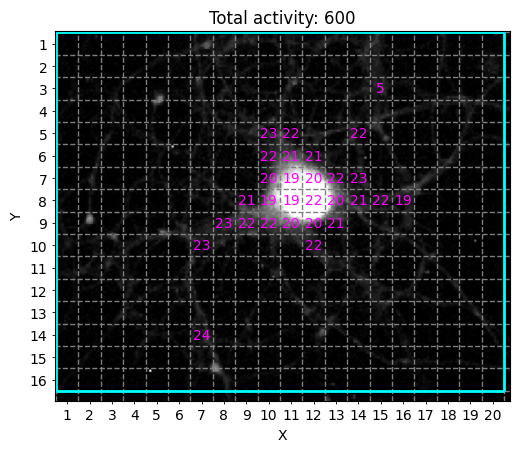

In [ ]:
# confirm that model can be executed:
assert test_correct_model_run() is None

results_dir = model.analysis_job_queue[0].results_dir_path

# confirm all csv files have been created and are correct:
assert test_all_peak_results(), 'There is an issue with the "all_peak_results.csv" file!'
assert test_amplitude_and_df_over_f_results()
assert test_auc_results()
assert test_variance_area_results()
assert test_representative_single_trace_results()

# confirm all other result files have been created:
assert test_activity_overview_png()
assert test_roi_label_ids_overview_png()
assert test_individual_traces_with_identified_events_pdf()
assert test_logs_txt()
assert test_user_settings_json()

Clean-up after testing:

In [ ]:
rmtree(results_dir)